In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Week 1 work
start_date = '1990-01-01'
end_date = '2024-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)
sp500_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
1990-01-01,329.079987,360.589996,319.829987,353.399994,3793250000
1990-02-01,331.890015,336.089996,322.100006,329.079987,2961970000
1990-03-01,339.940002,344.489990,331.079987,331.890015,3283280000
1990-04-01,330.799988,347.299988,327.760010,339.940002,2801220000
1990-05-01,361.230011,362.260010,330.799988,330.799988,3596680000


In [3]:
sp500_data = sp500_data[['Close']].dropna()

sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

sp500_data.dropna(inplace=True)

/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


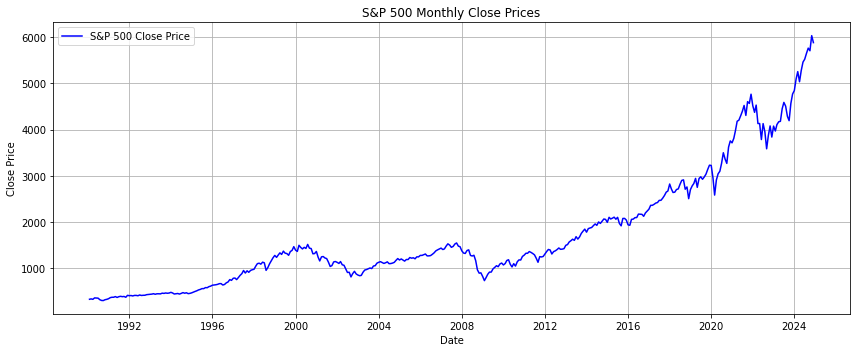

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

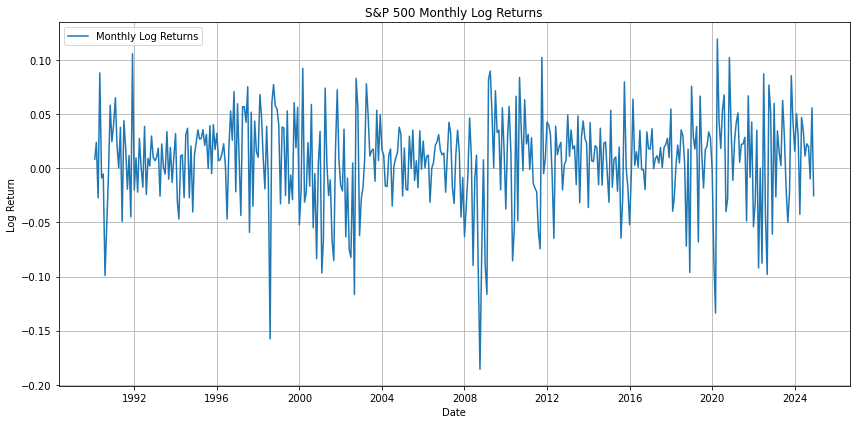

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

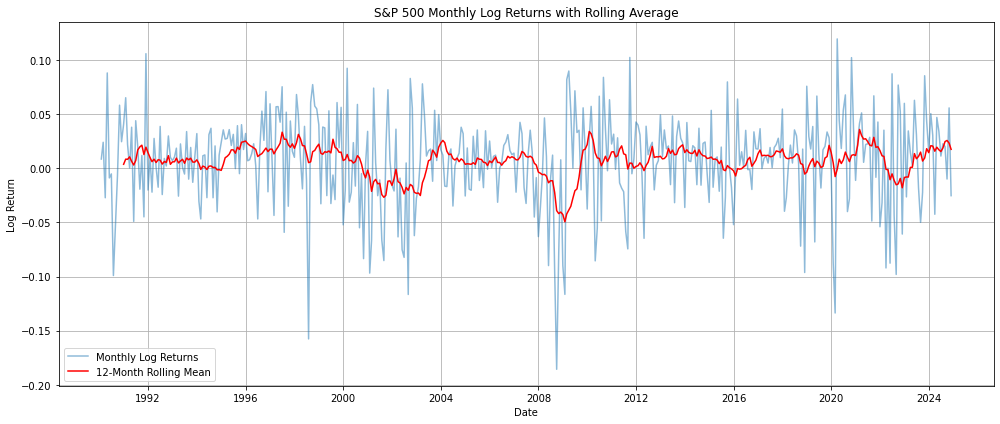

In [6]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

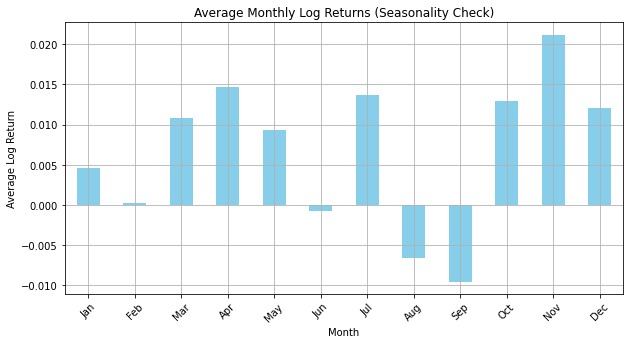

In [7]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 864x432 with 0 Axes>

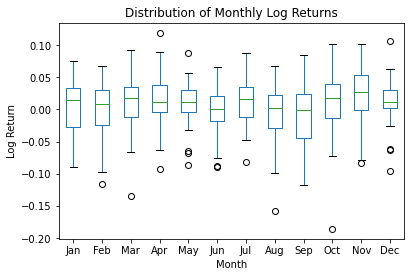

In [8]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [9]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -20.437488
p-value: 0.000000
Critical Values:
	1%: -3.4460914174990296
	5%: -2.868479374038333
	10%: -2.570466459559076


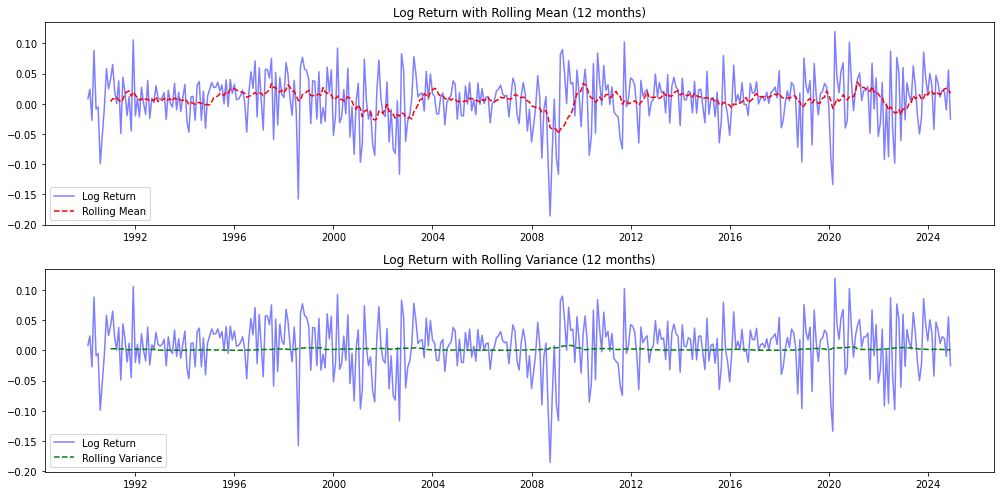

In [10]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

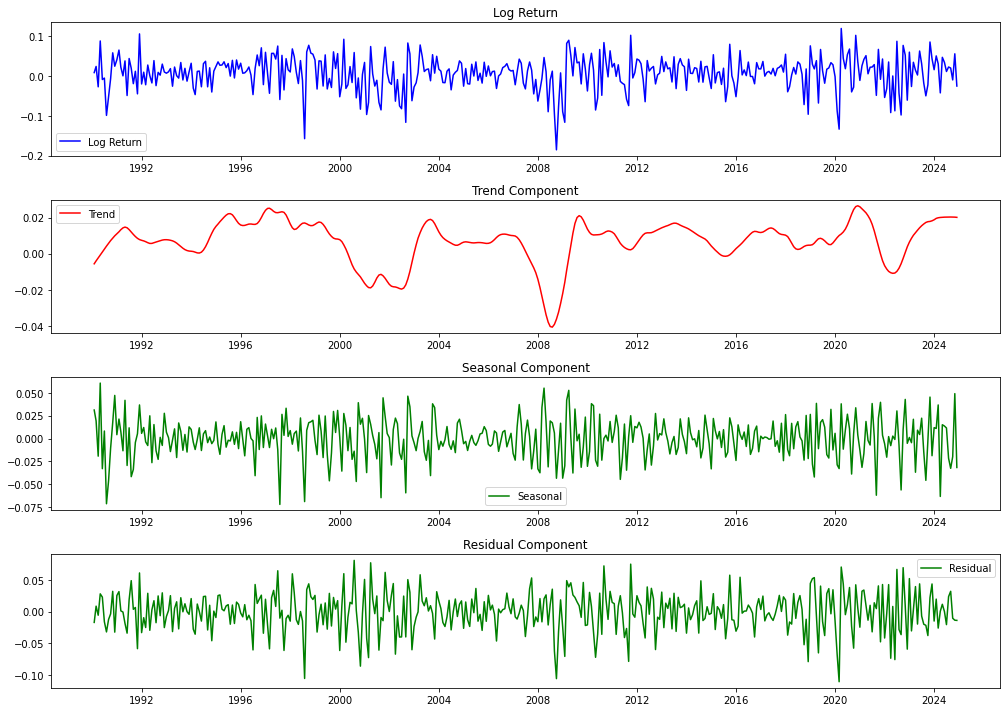

In [11]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-package

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  419
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 724.898
Date:                Mon, 21 Apr 2025   AIC                          -1441.795
Time:                        20:21:52   BIC                          -1425.644
Sample:                    02-01-1990   HQIC                         -1435.411
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.002      2.869      0.004       0.002       0.012
ar.L1      -3.167e-06      0.019     -0.000      1.000      -0.038       0.038
ma.L1      -3.178e-06      0.01

The ARIMA(1,0,1) model applied to the S&P 500 monthly log returns reveals that the only statistically significant component is the constant term, estimated at 0.0069 (p = 0.004), which suggests an average monthly return of approximately 0.69%. Both the AR(1) and MA(1) terms are extremely close to zero and not statistically significant (p = 1.000), indicating that past values and past errors do not meaningfully explain current returns. This supports the common finding in financial time series that returns are largely unpredictable and lack autocorrelation. The residual diagnostics also show no significant autocorrelation (Ljung-Box p = 0.96), although the Jarque-Bera test (p = 0.00) suggests that the residuals deviate from normality, with slightly left-skewed and fat-tailed behavior. Overall, the ARIMA model captures a consistent average return but provides little additional insight from autoregressive or moving average components.









In [13]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.72024D+00    |proj g|=  2.00369D-02

At iterate    5    f= -1.72070D+00    |proj g|=  2.40022D-02

At iterate   10    f= -1.72072D+00    |proj g|=  9.51414D-04

At iterate   15    f= -1.72072D+00    |proj g|=  3.10194D-02

At iterate   20    f= -1.72091D+00    |proj g|=  2.46352D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     29      1     0     0   3.425D-04  -1.721D+00
  F =  -1.7209447884594977     

CONVERG

The SARIMA model incorporates both short-term and seasonal components, but none of the autoregressive or moving average parameters (AR(1), MA(1), seasonal AR(12), seasonal MA(12)) are statistically significant—all have p-values well above 0.05, indicating they do not meaningfully contribute to explaining variation in the log returns. The only significant estimate is the error variance sigma², confirming that there is consistent variability in the returns. The model converged successfully after 24 iterations using the L-BFGS-B optimization algorithm, and while the SARIMA model fits slightly worse than the ARIMA model based on log-likelihood (721.08 vs. 724.90) and AIC (-1432.15 vs. -1441.80), residual diagnostics still show no major autocorrelation (Ljung-Box p = 0.67). Like the ARIMA model, the residuals deviate from normality (Jarque-Bera p = 0.00) and exhibit mild skewness and fat tails. Overall, the SARIMA model does not provide a clear improvement over the simpler ARIMA model.

In [14]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.680
Date:                Mon, 21 Apr 2025   Prob (F-statistic):             0.0755
Time:                        20:23:16   Log-Likelihood:                 734.20
No. Observations:                 419   AIC:                            -1444.
Df Residuals:                     407   BIC:                            -1396.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

The regression model tests for monthly seasonality in S&P 500 log returns using dummy variables for each month, with January as the baseline. The overall model explains only a small portion of the variance in returns (R² = 0.043), and the F-statistic (p = 0.0755) suggests the model is not statistically significant at the 5% level. None of the individual month coefficients are significant either, though November (coef = 0.0166, p = 0.106) is the closest to reaching significance. The intercept (January's average return) is also not significant (p = 0.532), meaning returns in January aren't meaningfully different from zero. The residuals show some deviation from normality (Jarque-Bera p < 0.001), with slight left skew and fat tails. Overall, this regression does not provide strong evidence of a January Effect or significant seasonal patterns in monthly log returns over the sample period.

/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/darcelypena/opt/anaconda3/lib/python3.9/site-package

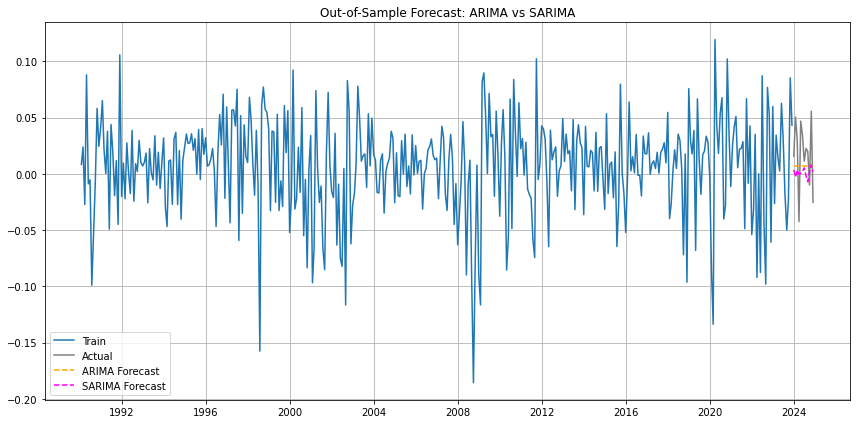

In [40]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

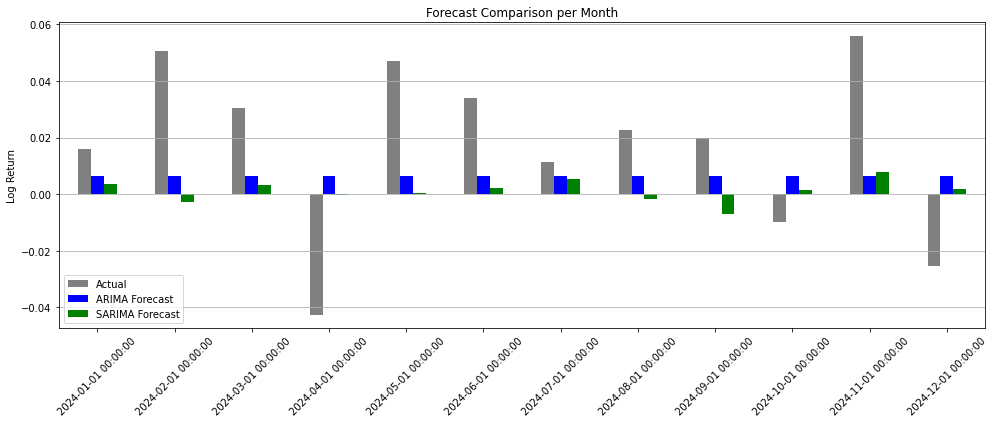

In [38]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

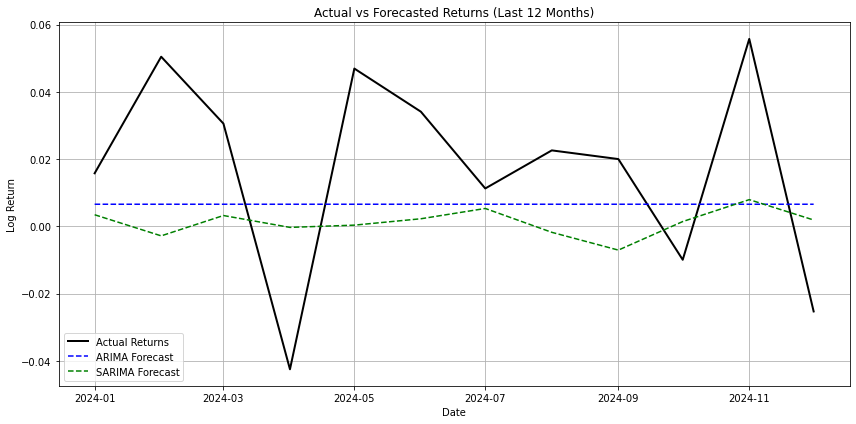

In [26]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.02714
ARIMA RMSE: 0.03101

SARIMA MAE: 0.02977
SARIMA RMSE: 0.03318


**Analysis:**

ARIMA outperforms SARIMA on both MAE and RMSE meaning it is more accurate overall even though it does not consider seasonality. This could suggest that seasonality wasn't strong in the last 12 months or that SARIMA didn’t capture it well with the parameters used.

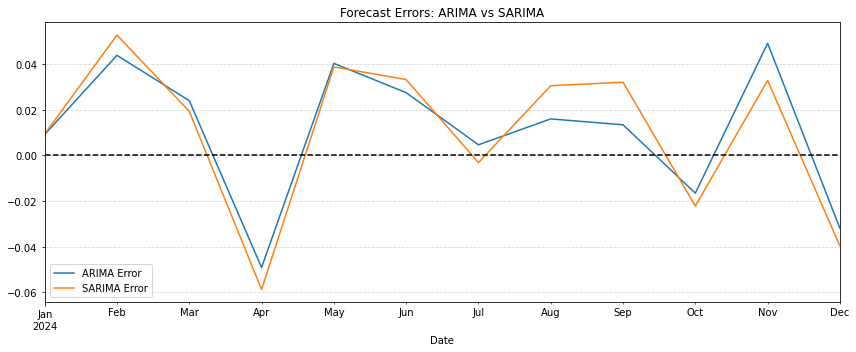

In [18]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()